In [ ]:
pip install torchvision


In [ ]:
import pandas as pd
import os
import scipy.ndimage as nd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import random
import glob
import nibabel as nib
import sys


In [ ]:
# Mount Google Drive at the specified path.
from google.colab import drive
drive.mount('/content/drive/')

# Add the specified directory to the system path.
sys.path.append('/content/drive/MyDrive/TFM/')

Mounted at /content/drive/


### **Load and prepare image dataset**

In [ ]:

# Assign the path to the directory containing brain extracted images.
path_to_images="/content/drive/MyDrive/TFM/Brain_Extracted_image_better/"

# Get a list of image names in the specified directory.
image_names= os.listdir(path_to_images)
len(image_names)

280

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Read a CSV file containing names and ages
names_age = pd.read_csv("/content/drive/My Drive/TFM/dataframe_names_age_better.csv")
names_age = names_age.reset_index(drop=True)

# Define a prefix for file paths.
prefix = '/content/drive/MyDrive/TFM/'
# Add the prefix to the 'filenames' column in the DataFrame.
names_age['filenames'] = names_age['filenames'].apply(lambda x: prefix + x)
names_age

(213, 251, 170)

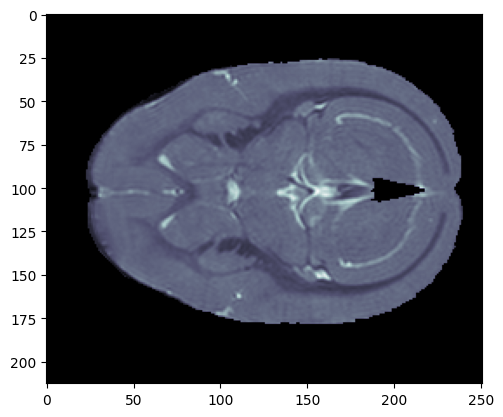

In [ ]:
# Example of MRI slice in the dataset
brain_image= nib.load(names_age["filenames"][1])


plt.imshow(brain_image.get_fdata()[:,:,100], cmap='bone')
print("Size of images: ", brain_image.get_fdata().shape)

In [ ]:
# Split dataset into training, validation and test data

from sklearn.model_selection import train_test_split
train_names, test_names = train_test_split(names_age, test_size=0.2, random_state=42)
train_names, val_names = train_test_split(train_names, test_size=0.2, random_state=42)

train_names = train_names.reset_index(drop=True)
test_names = test_names.reset_index(drop=True)
val_names = val_names.reset_index(drop=True)
# train_names = pd.concat([train_names, names_age_aug], ignore_index=True)

In [ ]:
# Take the values bigger than 40 months old and discard them

for month in train_names["age_months"]:
  if month>40:
    train_names=train_names.drop(train_names.loc[train_names['age_months'] ==month].index)


for month in val_names["age_months"]:
  if month>40:
    val_names=val_names.drop(val_names.loc[val_names['age_months'] ==month].index)

for month in test_names["age_months"]:
  if month>40:
    test_names=test_names.drop(test_names.loc[test_names['age_months'] ==month].index)


In the following three cells with make sure that the data from the same subject falls in the same partition of the dataset (train, validation or test)

In [ ]:
changerow=0
for trfilename in train_names["filenames"]:
  for vafilename in val_names["filenames"]:
    if trfilename==vafilename:
      changerow=1
      train_names=pd.concat([train_names,val_names.loc[train_names['filenames'] ==trfilename]],ignore_index=True)
      val_names=val_names.drop(val_names.loc[val_names['filenames'] ==trfilename].index)

    if changerow==1 and trfilename!=vafilename:
      changerow=0
      val_names=pd.concat([val_names,train_names.loc[train_names['filenames'] ==trfilename]],ignore_index=True)
      train_names=train_names.drop(train_names.loc[train_names['filenames'] ==trfilename].index)



In [ ]:
changerow=0
for trfilename in train_names["filenames"]:
  for tefilename in test_names["filenames"]:
    if trfilename==tefilename:
      changerow=1
      train_names=pd.concat([train_names,test_names.loc[train_names['filenames'] ==trfilename]],ignore_index=True)
      test_names=test_names.drop(test_names.loc[test_names['filenames'] ==trfilename].index)

    if changerow==1 and trfilename!=tefilename:
      changerow=0
      test_names=pd.concat([test_names,train_names.loc[train_names['filenames'] ==trfilename]],ignore_index=True)
      train_names=train_names.drop(train_names.loc[train_names['filenames'] ==trfilename].index)



In [ ]:
changerow=0
for vafilename in val_names["filenames"]:
  for tefilename in test_names["filenames"]:
    if vafilename==tefilename:
      changerow=1
      val_names=pd.concat([val_names,test_names.loc[val_names['filenames'] ==vafilename]],ignore_index=True)
      test_names=test_names.drop(test_names.loc[test_names['filenames'] ==vafilename].index)

    if changerow==1 and vafilename!=tefilename:
      changerow=0
      test_names=pd.concat([test_names,val_names.loc[val_names['filenames'] ==vafilename]],ignore_index=True)
      val_names=val_names.drop(val_names.loc[val_names['filenames'] ==vafilename].index)


In [ ]:
# Reset the indexes again after modifying the data inside

train_names = train_names.reset_index(drop=True)
test_names = test_names.reset_index(drop=True)
val_names = val_names.reset_index(drop=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize

class MRIDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths (list of str): List of paths to NIfTI images.
            labels (list of float): List of brain age labels corresponding to the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        img = nib.load(img_path).get_fdata()


        if self.transform:
            img = self.transform(img)

        return img, label

def create_mri_dataset(image_paths, labels, batch_size=32, shuffle=True, num_workers=4):
    """
    Creates a DataLoader for the MRI dataset.

    Args:
        image_paths (list of str): List of paths to NIfTI images.
        labels (list of float): List of brain age labels corresponding to the images.
        batch_size (int): How many samples per batch to load.
        shuffle (bool): Set to True to have the data reshuffled at every epoch.
        num_workers (int): How many subprocesses to use for data loading.

    Returns:
        DataLoader: DataLoader for the MRI dataset.
    """
    dataset = MRIDataset(image_paths, labels, transform=None)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    return dataloader




In [ ]:

# Assuming MRIDataset and create_mri_dataset are already defined as per the previous example

# Example image paths and labels (replace with your actual paths and labels)
train_image_paths = train_names["filenames"]  # List of file paths to your NIFTI images
train_labels = train_names["age_months"].tolist()      # List of corresponding labels
# Example image paths and labels (replace with your actual paths and labels)
val_image_paths = val_names["filenames"]  # List of file paths to your NIFTI images
val_labels = val_names["age_months"].tolist()      # List of corresponding labels
test_image_paths = test_names["filenames"]  # List of file paths to your NIFTI images
test_labels = test_names["age_months"].tolist()      # List of corresponding labels


### **Create DL ResNet model**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        '''
          Defines a residual block for a 3D convolutional neural network.
          Arguments:
            in_channels (int): The number of input channels.
            out_channels (int): The number of output channels.
            kernel_size (int, optional): The size of the convolutional kernel. Defaults to 3.
            stride (int, optional): The stride of the convolution. Defaults to 1.
            padding (int, optional): The padding of the convolution. Defaults to 1.
        '''
        super(ResBlock, self).__init__()

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.shortcut = nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class AgePredictionResNet(nn.Module):
    def __init__(self, input_shape=(213,251,170), dropout=0.2,include_scanner_gender=False):
        '''
        Defines a ResNet model for age prediction from 3D MRI data.
        Arguments:
          input_shape (tuple, optional): The shape of the input MRI data (depth, height, width). Defaults to (213, 251, 170).
          dropout (float, optional): The dropout rate. Defaults to 0.2.
          include_scanner_gender (bool, optional): Whether to include scanner and gender information as input. Defaults to False.
        '''
        super(AgePredictionResNet, self).__init__()

        self.include_scanner_gender = include_scanner_gender

        self.conv1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(8)
        self.res_block0 = ResBlock(8, 8)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.res_block1 = ResBlock(8, 16)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.res_block2 = ResBlock(16, 32)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.res_block3 = ResBlock(32, 64)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.res_block4 = ResBlock(64, 128)
        self.pool5 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128*6*7*5, 128)
        self.dropout = nn.Dropout(dropout)

        if include_scanner_gender:
            self.scanner = nn.Linear(1, 128)
            self.gender = nn.Linear(1, 128)
            self.fc2 = nn.Linear(384, 1)
        else:
            self.fc2 = nn.Linear(128, 1)

    def forward(self, x, scanner=None, gender=None):
        x = self.conv1(x.float())
        x = self.bn1(x)
        x = F.relu(x)
        x = self.res_block0(x)
        x = self.pool1(x)
        x = self.res_block1(x)
        x = self.pool2(x)
        x = self.res_block2(x)
        x = self.pool3(x)
        x = self.res_block3(x)
        x = self.pool4(x)
        x = self.res_block4(x)
        x = self.pool5(x)
        x = x.view(-1, 128*6*7*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        if self.include_scanner_gender:
            scanner = F.relu(self.scanner(scanner))
            gender = F.relu(self.gender(gender))
            x = torch.cat([scanner, gender, x], dim=1)

        x = self.fc2(x)
        return x


### **Train the model**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda', regularization=None, alpha=0.01, l1_ratio=0.5, patience=10, use_both_dataloaders=False):
    """
    Train the model with optional regularization and early stopping.

    Arguments:
    - model: the neural network model
    - dataloaders: dictionary containing 'train' and 'val' DataLoader objects
    - criterion: the loss function
    - optimizer: the optimizer
    - num_epochs: number of epochs to train for
    - device: device to train on ('cuda' or 'cpu')
    - regularization: type of regularization ('l1', 'l2', or 'elasticnet')
    - alpha: regularization strength (common for both L1 and L2 in Elastic Net)
    - l1_ratio: mix between L1 and L2 regularization (only used if regularization is 'elasticnet')
    - patience: number of epochs to wait for improvement before stopping early
    - use_both_dataloaders: boolean to determine whether to use both train and val dataloaders for training

    Returns:
    - model: the trained model
    - train_loss: list of training losses
    - val_loss: list of validation losses
    - correlations: list of validation correlations for each epoch
    """
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    train_loss = []
    val_loss = []
    correlations = []
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # If use_both_dataloaders is True, combine 'train' and 'val' data loaders into one phase
        phases = ['train'] if use_both_dataloaders else ['train', 'val']

        # Each epoch has a training and validation phase
        for phase in phases:
            model.train()  # Set model to training mode
            running_loss = 0.0
            all_labels = []
            all_preds = []

            # Iterate over data
            for inputs, labels in dataloaders['train'] if phase == 'train' else dataloaders[phase]:
                inputs = inputs.unsqueeze(1).float().to(device)  # Add channel dimension and convert to float
                labels = labels.float().to(device)
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.unsqueeze(1))

                    if regularization is not None:
                        l1_penalty = torch.tensor(0., device=device)
                        l2_penalty = torch.tensor(0., device=device)

                        for param in model.parameters():
                            if regularization == 'l1' or regularization == 'elasticnet':
                                l1_penalty += torch.sum(torch.abs(param))
                            if regularization == 'l2' or regularization == 'elasticnet':
                                l2_penalty += torch.sum(param ** 2)

                        if regularization == 'l1':
                            loss += alpha * l1_penalty
                        elif regularization == 'l2':
                            loss += alpha * l2_penalty
                        elif regularization == 'elasticnet':
                            loss += alpha * (l1_ratio * l1_penalty + (1 - l1_ratio) * l2_penalty)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)

                # Collect all labels and predictions for correlation calculation
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(outputs.detach().cpu().numpy().flatten())

            epoch_loss = running_loss / len(dataloaders['train'].dataset if phase == 'train' else dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f}')
            if phase == 'train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)

                # Calculate and store the correlation between labels and predictions
                correlation, _ = pearsonr(all_labels, all_preds)
                correlations.append(correlation)
                print(f'Validation Correlation: {correlation:.4f}')
                print(correlations)

                # Deep copy the model if we get a new best validation loss
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        # Check early stopping condition
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch} with best validation loss: {best_loss:.4f}')
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_loss, val_loss, correlations


Epoch 0/49
----------
train Loss: 125.3696
Epoch 1/49
----------
train Loss: 56.6589
Epoch 2/49
----------
train Loss: 51.5502
Epoch 3/49
----------
train Loss: 41.3988
Epoch 4/49
----------
train Loss: 40.5570
Epoch 5/49
----------
train Loss: 33.5858
Epoch 6/49
----------
train Loss: 34.8697
Epoch 7/49
----------
train Loss: 28.2905
Epoch 8/49
----------
train Loss: 26.9704
Epoch 9/49
----------
train Loss: 24.0195
Epoch 10/49
----------
train Loss: 23.1578
Epoch 11/49
----------
train Loss: 20.3293
Epoch 12/49
----------
train Loss: 18.3406
Epoch 13/49
----------
train Loss: 18.1268
Epoch 14/49
----------
train Loss: 15.4009
Epoch 15/49
----------
train Loss: 14.7155
Epoch 16/49
----------
train Loss: 14.3680
Epoch 17/49
----------
train Loss: 15.2505
Epoch 18/49
----------
train Loss: 13.2896
Epoch 19/49
----------
train Loss: 11.2950
Epoch 20/49
----------
train Loss: 13.0303
Epoch 21/49
----------
train Loss: 10.7571
Epoch 22/49
----------
train Loss: 10.1919
Epoch 23/49
--------

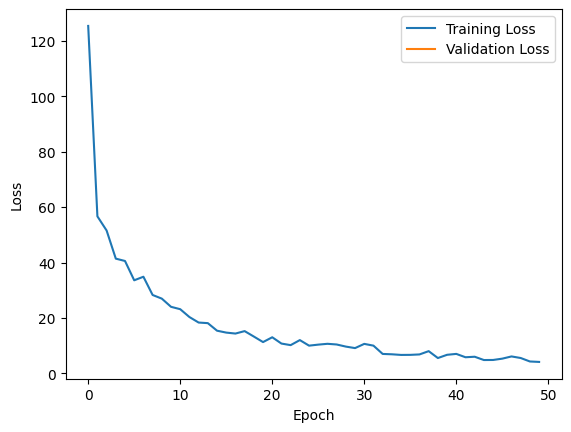

In [ ]:


# Create dataloaders
batch_size = 8
train_loader = create_mri_dataset(train_image_paths, train_labels, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = create_mri_dataset(val_image_paths, val_labels, batch_size=batch_size, shuffle=True, num_workers=0)

dataloaders = {'train': train_loader, 'val': val_loader}

# Initialize model, criterion, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AgePredictionResNet(dropout=0.2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Set regularization parameters
regularization = 'l2'  # or 'l1' or 'l2'
alpha = 1e-6
l1_ratio = 0.5

# Train the model
model, train_loss, val_loss,correlations = train_model(
    model, dataloaders, criterion, optimizer,
    num_epochs=50, device=device,
    regularization=regularization, alpha=alpha, use_both_dataloaders=True)

# Save the trained model
torch.save(model.state_dict(), 'best_model_l2_final.pth')

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **Evaluate the model**

In [ ]:
# Function for loading a pre-trained model if necessary
# import torch
# def load_model(model_path, device='cuda'):
#     # Initialize the model architecture
#     model = AgePredictionResNet(input_shape=(1, 213, 251, 170)).to(device)
#     # Load the state dictionary into the model
#     model.load_state_dict(torch.load(model_path, map_location=device))
#     model.eval()  # Set the model to evaluation mode
#     return model

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model_path = '/content/drive/MyDrive/TFM/best_model.pth'
# model = load_model(model_path, device)

In [ ]:
# Create a test dataset
test_dataset = MRIDataset(test_image_paths, test_labels, transform=None)

# Create a test dataloader
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, dataloader, device):
    model.eval()  # Ensure the model is in evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs = inputs.unsqueeze(1).float().to(device)  # Add channel dimension and convert to float
            labels = labels.float().to(device)

            outputs = model(inputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    # Calculate evaluation metrics
    mse = mean_squared_error(all_labels, all_preds)
    mae = mean_absolute_error(all_labels, all_preds)
    r2 = r2_score(all_labels, all_preds)

    return mse, mae, r2, all_preds, all_labels

# Evaluate the model on the test dataset
mse, mae, r2, preds, labels = evaluate_model(model, test_loader, device)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")
print(preds)
print(labels)


Mean Squared Error (MSE): 22.8237
Mean Absolute Error (MAE): 3.4988
R-squared (R2): 0.5447
[11.21077   18.4251    24.379116   8.278249  14.798635  14.27033
  8.357579  26.898249  21.429058  12.792471  26.113247   9.903071
 27.28448   11.399517  22.471699  24.197262  18.85335   10.815624
 23.941553  19.457993  10.831422   8.498287  20.760077  18.388672
 24.829588  22.522566   6.5670056 12.764448  18.579657  12.963335
 22.587646  13.730785  23.533688  20.284235  22.691267   8.252385
 15.301506   8.876035   8.572947  10.38049   10.576485  17.36392
  9.692347  21.088886  16.278852  22.625856   8.068073  17.06417
 18.823015  13.688465  12.322265  21.487947  22.31299   19.860785
 11.453864  15.199737 ]
[ 8.73922   14.521561  19.449692   3.5154004 13.9958935  9.659138
  3.2197125 18.858316  19.811089  11.00616   18.956879   9.462012
 18.66119   10.480493  19.5154    14.488707  19.318275   9.856263
 18.398357  37.486652   9.462012   3.6468172 18.66119   13.601643
 24.180698  23.227926   4.4681

In [ ]:
# import numpy as np
# preds=np.array([ 8.297784 , 21.28369  , 19.819809,   6.1749635, 14.071226  ,14.577001
#   ,9.667125,  28.317085 , 17.533274,   9.575127  ,25.032425 ,  8.382055
#  ,30.989151 , 10.344324  ,19.428886 , 18.14716   ,18.667336 ,  8.194417
#  ,31.879848   ,7.161845  , 6.4455285 ,21.568134 , 21.34366
#  ,25.727587  ,27.732622   ,7.704791  ,11.359583  ,18.884    , 10.089252
#  ,24.914694  , 6.317979  ,23.269442  ,24.627903  ,26.24659  ,  9.6245
#  ,12.612231  , 9.779798   ,8.718794  , 9.868359  , 9.337121 , 14.972368
#   ,7.802597  ,25.337357  ,17.264301  ,23.468092  , 8.639259 , 12.402634
#  ,17.737629  ,10.639906  ,11.815263  ,21.094246  ,20.886564 , 16.88874
#  ,10.461224  ,13.807999 ])
# labels=np.array([ 9., 15., 19.,  4., 14., 10.,  3., 19., 20., 11., 19.,  9., 19., 10., 20., 14., 19., 10.,
#  18.,  9.,  4. ,19., 14., 24., 23.,  4., 10., 28., 11., 22., 11., 21., 19., 21.,  4.,
#  14., 10.,  3.,  9.,  9., 19.,  4., 20., 15., 19.,  3., 17., 15., 10., 10., 20., 19., 21.,
#  11.,  3.])

16.501804 14.158403
Mean Squared Error (MSE): 22.8237
Mean Absolute Error (MAE): 3.4988
R-squared (R2): 0.5447


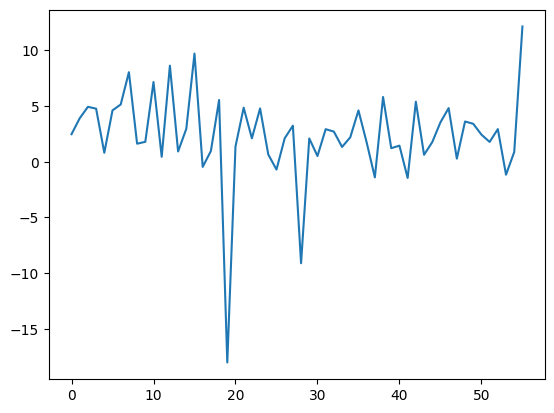

In [ ]:
import matplotlib.pyplot as plt

d=preds-labels
plt.plot(preds-labels)
print(np.mean(preds),np.mean(labels))
# Calculate evaluation metrics
mse = mean_squared_error(labels, preds)
mae = mean_absolute_error(labels, preds)
r2 = r2_score(labels, preds)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")


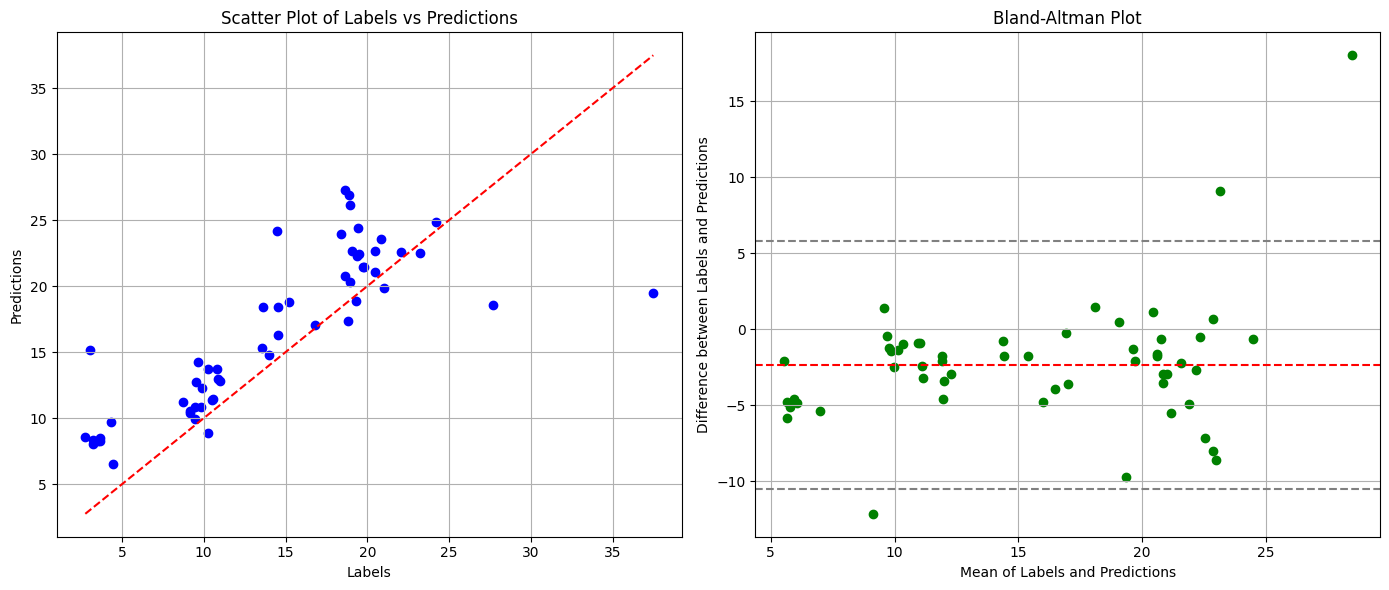

In [ ]:


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Correlation plot
axes[0].scatter(labels, preds, color='blue')
axes[0].plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'r--')  # Line y=x
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Predictions')
axes[0].set_title('Scatter Plot of Labels vs Predictions')
axes[0].grid(True)

# Bland-Altman plot
mean = np.mean([labels, preds], axis=0)
difference = labels - preds
mean_diff = np.mean(difference)
std_diff = np.std(difference)

axes[1].scatter(mean, difference, color='green')
axes[1].axhline(mean_diff, color='red', linestyle='--')
axes[1].axhline(mean_diff + 1.96*std_diff, color='grey', linestyle='--')
axes[1].axhline(mean_diff - 1.96*std_diff, color='grey', linestyle='--')
axes[1].set_xlabel('Mean of Labels and Predictions')
axes[1].set_ylabel('Difference between Labels and Predictions')
axes[1].set_title('Bland-Altman Plot')
axes[1].grid(True)

plt.tight_layout()
plt.show()

For Monte Carlo dropout

In [ ]:
import sys
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn

def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def get_monte_carlo_predictions(dataloader,
                                forward_passes,
                                model):
    """ Function to get the monte-carlo samples and uncertainty estimates
    through multiple forward passes

    Parameters
    ----------
    data_loader : object
        data loader object from the data loader module
    forward_passes : int
        number of monte-carlo samples/forward passes
    model : object
        keras model
    n_classes : int
        number of classes in the dataset
    n_samples : int
        number of samples in the test set
    """

    dropout_predictions = []
    for i in tqdm(range(forward_passes)):
        model.eval()
        enable_dropout(model)
        with torch.no_grad():  # Disable gradient calculation
              all_preds = []
              all_labels = []
              for inputs, labels in dataloader:
                  inputs = inputs.unsqueeze(1).float().to(device)  # Add channel dimension and convert to float
                  labels = labels.float().to(device)

                  outputs = model(inputs)
                  all_preds.extend(outputs.cpu().numpy())
                  all_labels.extend(labels.cpu().numpy())
              dropout_predictions.append(all_preds)


        # dropout predictions - shape (forward_passes, predictions)
    dropout_predictions = np.array(dropout_predictions)
    # Calculating mean across multiple MCD forward passes
    mean = np.mean(dropout_predictions, axis=0)  # shape (n_samples, n_classes)

    # Calculating variance across multiple MCD forward passes
    variance = np.var(dropout_predictions, axis=0)  # shape (n_samples, n_classes)

    epsilon = sys.float_info.min
    # Calculating entropy across multiple MCD forward passes
    entropy = -np.sum(mean * np.log(mean + epsilon), axis=-1)  # shape (n_samples,)

    # Calculating mutual information across multiple MCD forward passes
    mutual_info = entropy - np.mean(np.sum(-dropout_predictions * np.log(dropout_predictions + epsilon),
                                           axis=-1), axis=0)  # shape (n_samples,)

    return dropout_predictions, mean, variance, entropy, mutual_info

  #  with torch.no_grad():  # Disable gradient calculation
  #       for inputs, labels in dataloader:
  #           inputs = inputs.unsqueeze(1).float().to(device)  # Add channel dimension and convert to float
  #           labels = labels.float().to(device)

  #           outputs = model(inputs)
  #           all_preds.extend(outputs.cpu().numpy())
  #           all_labels.extend(labels.cpu().numpy())


In [ ]:
dropout_predictions,mean_dropout, variance, entropy, mutual_info = get_monte_carlo_predictions(test_loader, 10, model)

In [ ]:
mean_dropout=np.transpose(mean_dropout)

In [ ]:
import matplotlib.pyplot as plt

d=preds-labels
plt.plot(mean_dropout-labels)
print(np.mean(dropout_predictions),np.mean(labels))
# Calculate evaluation metrics
mse = mean_squared_error(labels, mean_dropout)
mae = mean_absolute_error(labels, mean_dropout)
r2 = r2_score(labels, mean_dropout)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")


In [ ]:


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Correlation plot
axes[0].scatter(labels, mean_dropout, color='blue')
axes[0].plot([labels.min(), labels.max()], [labels.min(), labels.max()], 'r--')  # Line y=x
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Predictions')
axes[0].set_title('Scatter Plot of Labels vs Predictions')
axes[0].grid(True)

# Bland-Altman plot
mean = np.mean([labels, mean_dropout.reshape(-1)], axis=0)
difference = labels - np.transpose(mean_dropout.reshape(-1))
mean_diff = np.mean(difference)
std_diff = np.std(difference)

axes[1].scatter(mean, difference, color='green')
axes[1].axhline(mean_diff, color='red', linestyle='--')
axes[1].axhline(mean_diff + 1.96*std_diff, color='grey', linestyle='--')
axes[1].axhline(mean_diff - 1.96*std_diff, color='grey', linestyle='--')
axes[1].set_xlabel('Mean of Labels and Predictions')
axes[1].set_ylabel('Difference between Labels and Predictions')
axes[1].set_title('Bland-Altman Plot')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
difference = labels - np.transpose(mean_dropout.reshape(-1))
difference.shape